# Netflix Movie Recommendation

Netflix - это объединение людей с любимыми фильмами. Чтобы помочь клиентам найти эти фильмы, они разработали систему рекомендаций для фильмов мирового уровня: CinematchSM. Его работа состоит в том, чтобы предсказать, понравится ли кому-нибудь фильм, основываясь на том, насколько ему понравились или не понравились другие фильмы. Netflix использует эти прогнозы для составления персональных рекомендаций по фильмам на основе уникальных вкусов каждого клиента. И хотя у Cinematch дела идут хорошо, его всегда можно улучшить.

Netflix предоставил много анонимных рейтинговых данных и планку точности прогноза, которая на 10% лучше, чем Cinematch может сделать с тем же набором обучающих данных. (Точность - это показатель того, насколько точно прогнозируемые рейтинги фильмов соответствуют последующим фактическим рейтингам.)

Цели:

- Спрогнозировать рейтинг, который пользователь даст фильму, который он еще не оценил.
- Минимизировать разницу между прогнозируемым и фактическим рейтингом (RMSE и MAPE)

https://www.kaggle.com/netflix-inc/netflix-prize-data

In [6]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split 

In [7]:
import os

Data files :
- combined_data_1.txt
- combined_data_2.txt
- combined_data_3.txt
- combined_data_4.txt
- movie_titles.csv
- probe.txt

In [1]:
data = open('dataset/data.csv', mode='w')
row = list()
files=['dataset/combined_data_1.txt','dataset/combined_data_2.txt', 
       'dataset/combined_data_3.txt', 'dataset/combined_data_4.txt']
for file in files:
    with open(file) as f:
        for line in f: 
            del row[:] 
            line = line.strip()
            if line.endswith(':'):
                movie_id = line.replace(':', '')
            else:
                row = [x for x in line.split(',')]
                row.insert(0, movie_id)
                data.write(','.join(row))
                data.write('\n')
data.close()

In [8]:
data = pd.read_csv('dataset/data.csv', sep=',', names=['movie', 'user','rating','date'])

In [3]:
data.head()

,movie,user,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100480507 entries, 0 to 100480506
Data columns (total 4 columns):
movie     int64
user      int64
rating    int64
date      object
dtypes: int64(3), object(1)
memory usage: 3.0+ GB


Movie варьируeтся от 1 до 17770.

User от 1 до 2649429.

Rating выставляется по шкале от 1 до 5.

Date имеет формат гггг-ММ-ДД.

In [11]:
data.shape

(100480507, 4)

Проверим, имеются ли пустые, незаполненные ячейки в выборке

In [14]:
data.isnull().any().any()

False

In [12]:
data.describe()

,movie,user,rating
count,1.004805e+08,1.004805e+08,1.004805e+08
mean,9.070915e+03,1.322489e+06,3.604290e+00
std,5.131891e+03,7.645368e+05,1.085219e+00
min,1.000000e+00,6.000000e+00,1.000000e+00
25%,4.677000e+03,6.611980e+05,3.000000e+00
50%,9.051000e+03,1.319012e+06,4.000000e+00
75%,1.363500e+04,1.984455e+06,4.000000e+00
max,1.777000e+04,2.649429e+06,5.000000e+00


Проверим на дубликаты

In [4]:
duplicates = data.duplicated(["movie","user", "rating"])
print("Число дубликатов = "+str(duplicates.sum()))

Число дубликатов = 0


In [9]:
if not os.path.isfile('train.csv'):
    data.iloc[:int(data.shape[0]*0.80)].to_csv("train.csv", index=False)

if not os.path.isfile('test.csv'):
    data.iloc[int(data.shape[0]*0.80):].to_csv("test.csv", index=False)

train_data = pd.read_csv("train.csv", parse_dates=['date'])
test_data = pd.read_csv("test.csv")

In [11]:
def changingLabels(number):
    return str(number/10**6) + "M"

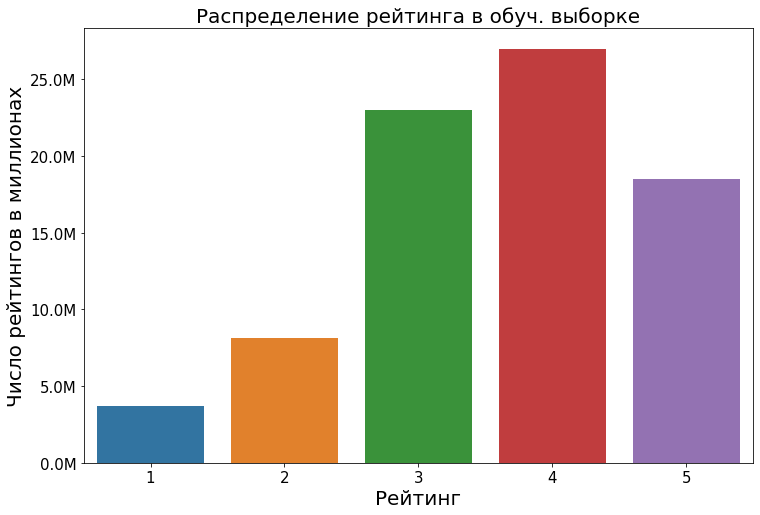

In [13]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="rating", data=train_data)

ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Распределение рейтинга в обуч. выборке", fontsize = 20)
plt.xlabel("Рейтинг", fontsize = 20)
plt.ylabel("Число рейтингов в миллионах", fontsize = 20)
plt.show()